<a href="https://colab.research.google.com/github/iskra3138/colab_repo/blob/master/Keras_CNNVisualization_MVTEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Jan 23 19:10:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    31W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
cd '/gdrive/My Drive/MVTEC_LEATHER/EXP/'

/gdrive/My Drive/MVTEC_LEATHER/EXP


# CAM Visualization

### import keras model

In [0]:
import tensorflow as tf
import keras

model = keras.models.load_model('my_mvtec_model.h5')
#model.summary()

### import matplotlib, numpy, cv2

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import cv2

### import modules

In [0]:
#@title import Grad CAM Code
from keras.preprocessing import image
import keras.backend as K

import numpy as np
import cv2


def load_image(path, target_size=(224, 224)):
    x = image.load_img(path, target_size=target_size)
    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = x/255.0

    return x


class GradCAM:
    def __init__(self, model, activation_layer, class_idx):
        self.model = model
        self.activation_layer = activation_layer
        self.class_idx = class_idx
        self.tensor_function = self._get_gradcam_tensor_function()

    # get partial tensor graph of CNN model
    def _get_gradcam_tensor_function(self):
        model_input = self.model.input
        y_c = self.model.outputs[0].op.inputs[0][0, self.class_idx]
        A_k = self.model.get_layer(self.activation_layer).output

        tensor_function = K.function([model_input], [A_k, K.gradients(y_c, A_k)[0]])
        return tensor_function

    # generate Grad-CAM
    def generate(self, input_tensor):
        [conv_output, grad_val] = self.tensor_function([input_tensor])
        conv_output = conv_output[0]
        grad_val = grad_val[0]

        weights = np.mean(grad_val, axis=(0, 1))

        grad_cam = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
        for k, w in enumerate(weights):
            grad_cam += w * conv_output[:, :, k]

        grad_cam = np.maximum(grad_cam, 0)

        return grad_cam, weights


class CAM:
    def __init__(self, model, activation_layer, class_idx):
        self.model = model
        self.activation_layer = activation_layer
        self.class_idx = class_idx
        self.tensor_function = self._get_cam_tensor_function()

    # get partial tensor graph of CNN model
    def _get_cam_tensor_function(self):
        model_input = self.model.input

        A_k = self.model.get_layer(self.activation_layer).output

        tensor_function = K.function([model_input], [A_k])
        return tensor_function

    # generate CAM
    def generate(self, input_tensor):
        [conv_output] = self.tensor_function([input_tensor])
        conv_output = conv_output[0]

        weights = self.model.layers[-1].get_weights()[0][:, self.class_idx]

        cam = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
        for k, w in enumerate(weights):
            cam += w * conv_output[:, :, k]

        return cam, weights

In [0]:
#@title import Guided Backpropagation Code
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K

import tensorflow as tf
from tensorflow.python.framework import ops

import numpy as np
import cv2

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.common.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def load_image(path, target_size=(224, 224)):
    x = image.load_img(path, target_size=target_size)
    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = x/255.0

    return x


class VisConvolution:
    def __init__(self, model, activation_layer, method='GuidedBackProp'):
        self.model = model
        #self.model_func = model_func
        self.activation_layer = activation_layer

        if method == 'BackProp':
            self._register_backprop_gradient()
            self.guided_model = self._modify_graph('BackProp')
        elif method == 'DeconvNet':
            self._register_deconvnet_gradient()
            self.guided_model = self._modify_graph('DeconvNet')
        elif method == 'GuidedBackProp':
            self._register_guidedbackprop_gradient()
            self.guided_model = self._modify_graph('GuidedBackProp')
        else:
            sys.exit('method must be (BackProp, DeconvNet, GuidedBackProp)')

        self.tensor_function = self.get_tensor_function()

    # register gradient
    def _register_backprop_gradient(self):
        if "BackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("BackProp")
            def _BackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(op.inputs[0] > 0., dtype)

    def _register_deconvnet_gradient(self):
        if "DeconvNet" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("DeconvNet")
            def _DeconvNet(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype)

    def _register_guidedbackprop_gradient(self):
        if "GuidedBackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("GuidedBackProp")
            def _GuidedBackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype) * \
                       tf.cast(op.inputs[0] > 0., dtype)

    # modify model graph
    def _modify_graph(self, name):
        config = model.get_config()
        weights = model.get_weights()
        g = tf.get_default_graph()
        with g.gradient_override_map({'Relu': name}):

            # get layers that have an activation
            layer_dict = [layer for layer in self.model.layers[1:]
                          if hasattr(layer, 'activation')]

            # replace relu activation
            for layer in layer_dict:
                if layer.activation == keras.activations.relu:
                    layer.activation = tf.nn.relu

            # re-instanciate a new model
            K.reset_uids()
            #new_model = self.model_func(weights='imagenet')
            new_model = keras.Model.from_config(config)
            new_model.set_weights(weights)
        return new_model

    # get partial tensor graph of CNN model
    def get_tensor_function(self, method='max', channel=0):
        model_input = self.guided_model.input
        layer_output = self.guided_model.get_layer(self.activation_layer).output

        if method == 'max':
            output = K.max(layer_output, axis=3)
        elif method == 'one':
            output = layer_output[:, :, :, channel]
        else:
            sys.exit('method must be (max, one)')

        tensor_function = K.function([model_input], [K.gradients(output, model_input)[0]])
        return tensor_function

    # generate saliency map(gradient)
    def generate(self, input_tensor):
        saliency = self.tensor_function([input_tensor])

        return saliency[0]

In [0]:
#@title import Util code
import keras.backend as K

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.common.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## read NGimage path

In [0]:
import glob, random

img_paths=[]
for i in range(5):
  img_paths.append(random.choice(glob.glob('/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/NG/*.jpg')))

In [10]:
img_paths

['/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/NG/cut_011_9_10.jpg',
 '/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/NG/cut_011_8_0.jpg',
 '/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/NG/cut_002_5_2.jpg',
 '/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/NG/cut_008_5_11.jpg',
 '/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/NG/cut_007_9_6.jpg']

### generate cam(class activation map)

In [11]:
%%time
img_width = 224
img_height = 224

#model = ResNet50(weights='imagenet')
activation_layer =  'conv5_block3_out'

#cams = []
gradcams = []
cam_weights = []
gradcam_weights = []
for img_path in img_paths:
    img = load_image(path=img_path, target_size=(img_width, img_height))

    preds = model.predict(img)
    predicted_class = preds.argmax(axis=1)[0]
    print (predicted_class)

    #cam_generator = CAM(model, activation_layer, predicted_class)
    gardcam_generator = GradCAM(model, activation_layer, predicted_class)
    
    #cam, cam_weight = cam_generator.generate(img)
    #cams.append(cam)
    #cam_weights.append(cam_weight)
    
    gradcam, gradcam_weight = gardcam_generator.generate(img)
    gradcams.append(gradcam)
    gradcam_weights.append(gradcam_weight)

0
0
0
0
0
CPU times: user 18.9 s, sys: 980 ms, total: 19.9 s
Wall time: 21.6 s


### Guided Backpropagation

In [12]:
%%time
'''import sys
sys.path.insert(0, '../utils')
sys.path.insert(0, '../keras-GuidedBackpropagation')

from utils import deprocess_image
from vis_convolution import VisConvolution
'''
vis_conv = VisConvolution(model,activation_layer)

gradient = []
for img_path in img_paths:
    img = load_image(path=img_path, target_size=(img_width, img_height))
    gradient.append(vis_conv.generate(img))

CPU times: user 31.3 s, sys: 597 ms, total: 31.9 s
Wall time: 31.9 s


### Plot CAM

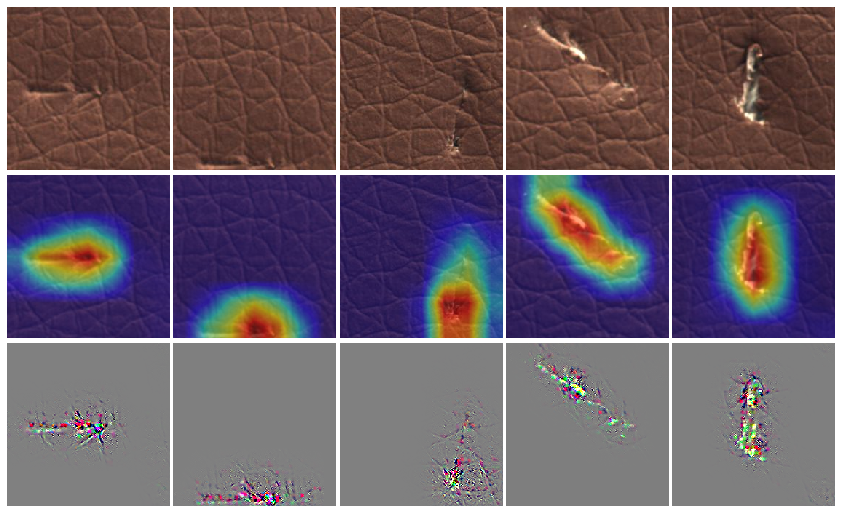

In [13]:
plt.figure(figsize=(20, 10))
left  = 0.125  # the left side of the subplots of the figure
right = 0.7    # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.02  # the amount of width reserved for blank space between subplots
hspace = 0.0   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, right=right, bottom=bottom, top=top, wspace=wspace, hspace=hspace)

for idx in range(len(gradcams)):
    #cams[idx] = cv2.resize(cams[idx], (img_width, img_height))
    gradcams[idx] = cv2.resize(gradcams[idx], (img_width, img_height))
    
    img = cv2.imread(img_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    
    plt.subplot(3, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(3, 5, 5 + idx+1)
    plt.imshow(img)
    plt.imshow(gradcams[idx], cmap="jet", alpha=.5)
    plt.axis('off')
    
    guided_gradcam = gradient[idx] * gradcams[idx][..., np.newaxis]
    guided_gradcam = deprocess_image(guided_gradcam)
    guided_gradcam = cv2.cvtColor(guided_gradcam, cv2.COLOR_RGB2BGR)
    plt.subplot(3, 5, 10 + idx+1)
    plt.imshow(guided_gradcam)
    plt.axis('off')

### compare 

$$a_k^c = \frac{1}{Z}\sum _i\sum_j\frac{\partial y^c}{\partial A^k_{i,j}}$$ 

$$w_k^c = \sum _i\sum_j\frac{\partial y^c}{\partial A^k_{i,j}}$$ 

$$Za_k^c = w_k^c$$

- activation conv layer의 shape 계산
- Z (activation conv 출력 feature map의 pixel 수)

In [14]:
print(gradcam_weights[0] * 7)

[-0.00610842 -0.00204709  0.00182275 ... -0.00662503  0.00486449
 -0.00677161]


## read OK image path

In [0]:
import glob, random

img_paths=[]
for i in range(5):
  img_paths.append(random.choice(glob.glob('/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/OK/*.jpg')))

In [16]:
img_paths

['/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/OK/good_027_9_15.jpg',
 '/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/OK/good_029_16_12.jpg',
 '/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/OK/good_030_14_18.jpg',
 '/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/OK/good_026_9_0.jpg',
 '/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/OK/good_030_2_18.jpg']

### generate cam(class activation map)

In [17]:
%%time
img_width = 224
img_height = 224

#model = ResNet50(weights='imagenet')
activation_layer =  'conv5_block3_out'

#cams = []
gradcams = []
cam_weights = []
gradcam_weights = []
for img_path in img_paths:
    img = load_image(path=img_path, target_size=(img_width, img_height))

    preds = model.predict(img)
    predicted_class = preds.argmax(axis=1)[0]
    print (predicted_class)

    #cam_generator = CAM(model, activation_layer, predicted_class)
    gardcam_generator = GradCAM(model, activation_layer, predicted_class)
    
    #cam, cam_weight = cam_generator.generate(img)
    #cams.append(cam)
    #cam_weights.append(cam_weight)
    
    gradcam, gradcam_weight = gardcam_generator.generate(img)
    gradcams.append(gradcam)
    gradcam_weights.append(gradcam_weight)

1
1
1
1
1
CPU times: user 20.7 s, sys: 267 ms, total: 21 s
Wall time: 22.4 s


### Guided Backpropagation

In [18]:
%%time
'''import sys
sys.path.insert(0, '../utils')
sys.path.insert(0, '../keras-GuidedBackpropagation')

from utils import deprocess_image
from vis_convolution import VisConvolution
'''
vis_conv = VisConvolution(model,activation_layer)

gradient = []
for img_path in img_paths:
    img = load_image(path=img_path, target_size=(img_width, img_height))
    gradient.append(vis_conv.generate(img))

CPU times: user 36.3 s, sys: 470 ms, total: 36.8 s
Wall time: 36.8 s


### Plot CAM

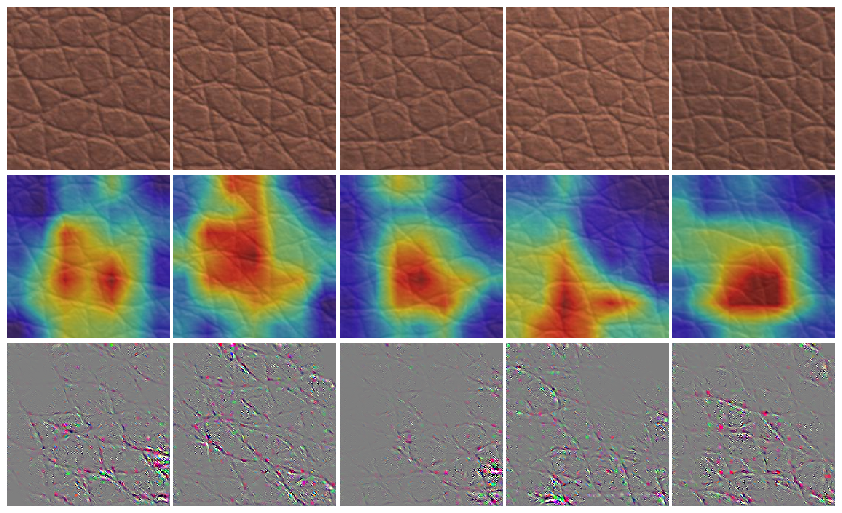

In [19]:
plt.figure(figsize=(20, 10))
left  = 0.125  # the left side of the subplots of the figure
right = 0.7    # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.02  # the amount of width reserved for blank space between subplots
hspace = 0.0   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, right=right, bottom=bottom, top=top, wspace=wspace, hspace=hspace)

for idx in range(len(gradcams)):
    #cams[idx] = cv2.resize(cams[idx], (img_width, img_height))
    gradcams[idx] = cv2.resize(gradcams[idx], (img_width, img_height))
    
    img = cv2.imread(img_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    
    plt.subplot(3, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(3, 5, 5 + idx+1)
    plt.imshow(img)
    plt.imshow(gradcams[idx], cmap="jet", alpha=.5)
    plt.axis('off')
    
    guided_gradcam = gradient[idx] * gradcams[idx][..., np.newaxis]
    guided_gradcam = deprocess_image(guided_gradcam)
    guided_gradcam = cv2.cvtColor(guided_gradcam, cv2.COLOR_RGB2BGR)
    plt.subplot(3, 5, 10 + idx+1)
    plt.imshow(guided_gradcam)
    plt.axis('off')

## read NG_Wrong image path

In [0]:
img_paths=['/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/NG/cut_011_1_19.jpg',
 '/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/NG/cut_011_3_19.jpg',
 '/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/NG/cut_011_7_0.jpg',
 '/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/NG/cut_011_11_1.jpg',
 '/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/NG/cut_011_11_19.jpg']

### generate cam(class activation map)

In [23]:
%%time
img_width = 224
img_height = 224

#model = ResNet50(weights='imagenet')
activation_layer =  'conv5_block3_out'

#cams = []
gradcams = []
cam_weights = []
gradcam_weights = []
for img_path in img_paths:
    img = load_image(path=img_path, target_size=(img_width, img_height))

    preds = model.predict(img)
    predicted_class = preds.argmax(axis=1)[0]
    print (predicted_class)

    #cam_generator = CAM(model, activation_layer, predicted_class)
    gardcam_generator = GradCAM(model, activation_layer, predicted_class)
    
    #cam, cam_weight = cam_generator.generate(img)
    #cams.append(cam)
    #cam_weights.append(cam_weight)
    
    gradcam, gradcam_weight = gardcam_generator.generate(img)
    gradcams.append(gradcam)
    gradcam_weights.append(gradcam_weight)

1
1
1
1
1
CPU times: user 24.7 s, sys: 326 ms, total: 25 s
Wall time: 26.2 s


### Guided Backpropagation

In [24]:
%%time
'''import sys
sys.path.insert(0, '../utils')
sys.path.insert(0, '../keras-GuidedBackpropagation')

from utils import deprocess_image
from vis_convolution import VisConvolution
'''
vis_conv = VisConvolution(model,activation_layer)

gradient = []
for img_path in img_paths:
    img = load_image(path=img_path, target_size=(img_width, img_height))
    gradient.append(vis_conv.generate(img))

CPU times: user 39.6 s, sys: 533 ms, total: 40.1 s
Wall time: 40.2 s


### Plot CAM

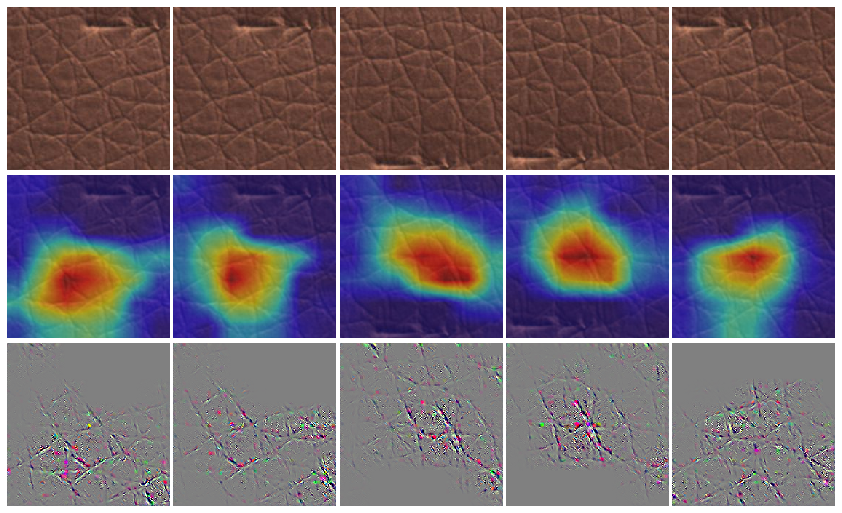

In [25]:
plt.figure(figsize=(20, 10))
left  = 0.125  # the left side of the subplots of the figure
right = 0.7    # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.02  # the amount of width reserved for blank space between subplots
hspace = 0.0   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, right=right, bottom=bottom, top=top, wspace=wspace, hspace=hspace)

for idx in range(len(gradcams)):
    #cams[idx] = cv2.resize(cams[idx], (img_width, img_height))
    gradcams[idx] = cv2.resize(gradcams[idx], (img_width, img_height))
    
    img = cv2.imread(img_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    
    plt.subplot(3, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(3, 5, 5 + idx+1)
    plt.imshow(img)
    plt.imshow(gradcams[idx], cmap="jet", alpha=.5)
    plt.axis('off')
    
    guided_gradcam = gradient[idx] * gradcams[idx][..., np.newaxis]
    guided_gradcam = deprocess_image(guided_gradcam)
    guided_gradcam = cv2.cvtColor(guided_gradcam, cv2.COLOR_RGB2BGR)
    plt.subplot(3, 5, 10 + idx+1)
    plt.imshow(guided_gradcam)
    plt.axis('off')

## read NG Train image path

In [0]:
import glob, random

img_paths=[]
for i in range(5):
  img_paths.append(random.choice(glob.glob('/gdrive/My Drive/MVTEC_LEATHER/EXP/Train/NG/*.jpg')))

In [27]:
img_paths

['/gdrive/My Drive/MVTEC_LEATHER/EXP/Train/NG/glue_011_2_2.jpg',
 '/gdrive/My Drive/MVTEC_LEATHER/EXP/Train/NG/color_006_6_6.jpg',
 '/gdrive/My Drive/MVTEC_LEATHER/EXP/Train/NG/poke_008_16_11.jpg',
 '/gdrive/My Drive/MVTEC_LEATHER/EXP/Train/NG/color_010_2_14.jpg',
 '/gdrive/My Drive/MVTEC_LEATHER/EXP/Train/NG/glue_005_7_7.jpg']

### generate cam(class activation map)

In [28]:
%%time
img_width = 224
img_height = 224

#model = ResNet50(weights='imagenet')
activation_layer =  'conv5_block3_out'

#cams = []
gradcams = []
cam_weights = []
gradcam_weights = []
for img_path in img_paths:
    img = load_image(path=img_path, target_size=(img_width, img_height))

    preds = model.predict(img)
    predicted_class = preds.argmax(axis=1)[0]
    print (predicted_class)

    #cam_generator = CAM(model, activation_layer, predicted_class)
    gardcam_generator = GradCAM(model, activation_layer, predicted_class)
    
    #cam, cam_weight = cam_generator.generate(img)
    #cams.append(cam)
    #cam_weights.append(cam_weight)
    
    gradcam, gradcam_weight = gardcam_generator.generate(img)
    gradcams.append(gradcam)
    gradcam_weights.append(gradcam_weight)

0
0
0
0
0
CPU times: user 31.3 s, sys: 440 ms, total: 31.7 s
Wall time: 33.5 s


### Guided Backpropagation

In [29]:
%%time
'''import sys
sys.path.insert(0, '../utils')
sys.path.insert(0, '../keras-GuidedBackpropagation')

from utils import deprocess_image
from vis_convolution import VisConvolution
'''
vis_conv = VisConvolution(model,activation_layer)

gradient = []
for img_path in img_paths:
    img = load_image(path=img_path, target_size=(img_width, img_height))
    gradient.append(vis_conv.generate(img))

CPU times: user 44.4 s, sys: 603 ms, total: 45 s
Wall time: 45 s


### Plot CAM

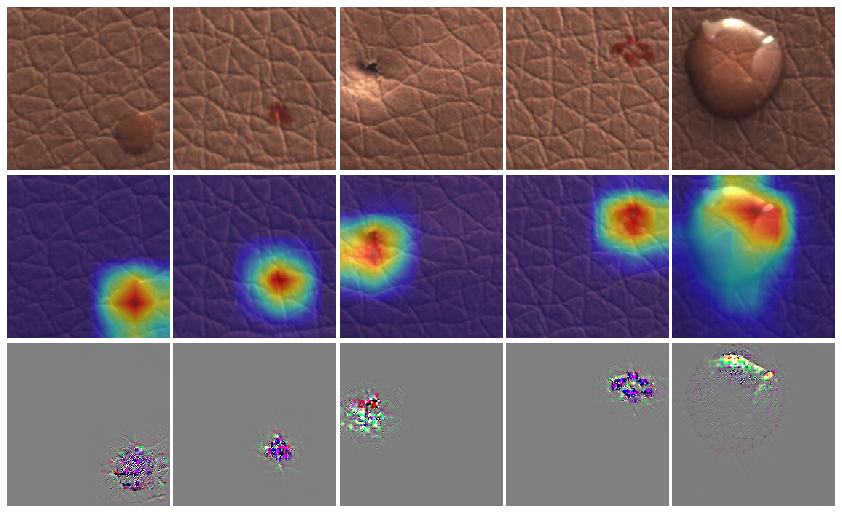

In [30]:
plt.figure(figsize=(20, 10))
left  = 0.125  # the left side of the subplots of the figure
right = 0.7    # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.02  # the amount of width reserved for blank space between subplots
hspace = 0.0   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, right=right, bottom=bottom, top=top, wspace=wspace, hspace=hspace)

for idx in range(len(gradcams)):
    #cams[idx] = cv2.resize(cams[idx], (img_width, img_height))
    gradcams[idx] = cv2.resize(gradcams[idx], (img_width, img_height))
    
    img = cv2.imread(img_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    
    plt.subplot(3, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(3, 5, 5 + idx+1)
    plt.imshow(img)
    plt.imshow(gradcams[idx], cmap="jet", alpha=.5)
    plt.axis('off')
    
    guided_gradcam = gradient[idx] * gradcams[idx][..., np.newaxis]
    guided_gradcam = deprocess_image(guided_gradcam)
    guided_gradcam = cv2.cvtColor(guided_gradcam, cv2.COLOR_RGB2BGR)
    plt.subplot(3, 5, 10 + idx+1)
    plt.imshow(guided_gradcam)
    plt.axis('off')